In [2]:
#! python
#from pyFWI import *
from FWIFunctions import *
import sys, re, datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


## The requirements of the FWI calculation stipulate that 
### 2 m temperature (∘C), 10 m wind speed (km h−1), and 2 m relative humidity (%) measurements be taken at noon LST for each global time zone and that precipitation (mm) be accumulated over the previous 24 h ending at noon LST of each day 

In [12]:
import xarray as xr

# Load the NetCDF file
file_path = "~/Downloads/fire_weather_index_2018.nc"  # Replace with your NetCDF file path
ds = xr.open_dataset(file_path)

# View the dataset
print(ds)

ds2=np.zeros(ds.FWI.shape,float)

#ds.rio.write_crs(4326, inplace=True)
#ds.rio.set_spatial_dims(x_dim=ds.Longitude, y_dim=ds.Latitude, inplace=True)
#ds.rio.write_coordinate_system(inplace=True)

<xarray.Dataset>
Dimensions:    (Longitude: 1440, Latitude: 721, Time: 365)
Coordinates:
  * Longitude  (Longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * Latitude   (Latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * Time       (Time) float64 1.0 2.0 3.0 4.0 5.0 ... 362.0 363.0 364.0 365.0
Data variables:
    crs        int32 ...
    FWI        (Time, Latitude, Longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.0-7)
    date:         2019-10-16 00:07:54


In [80]:
fwi = ds.FWI
#fwi.Longitude -= 180 if fwi.Longitude >= 180 else fwi.Longitude
#fwi.Longitude[fwi.Longitude >= 180]=0
fwi['Longitude'] = fwi['Longitude'].where(fwi['Longitude'] < 180, fwi['Longitude']-360)
## reorder the longitude
fwi_sorted = fwi.sortby('Longitude')

## change the content of fwi

(45.0, 50.0)

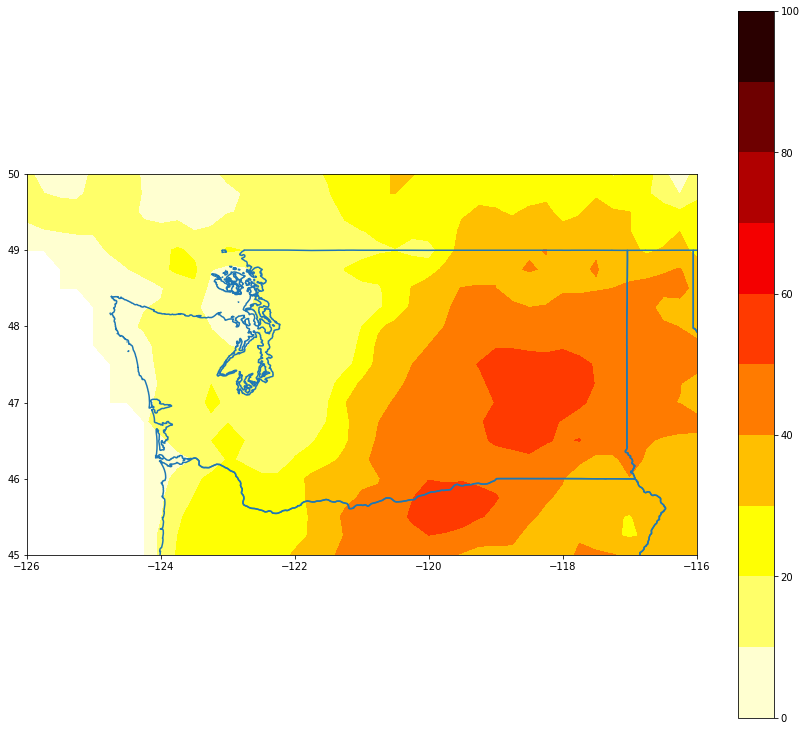

In [110]:
fig, ax = plt.subplots(figsize=(15, 13))
contours=ax.contourf(fwi_sorted.Longitude, fwi_sorted.Latitude, fwi_sorted[210:240,:,:].mean('Time'),
                     levels=np.linspace(0,100,11),
                    cmap='hot_r')
plt.colorbar(contours,extend='both')
states.boundary.plot(ax=ax)
ax.set_xlim([-126,-116])
ax.set_ylim([45,50])

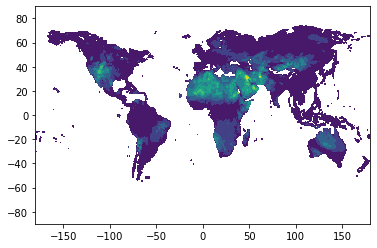

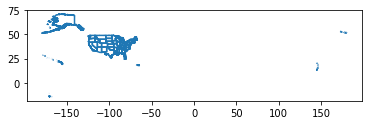

In [86]:
fwi_sorted
plt.contourf(fwi_sorted.Longitude, fwi_sorted.Latitude, fwi_sorted[160,:,:])
states.boundary.plot()
plt.show()

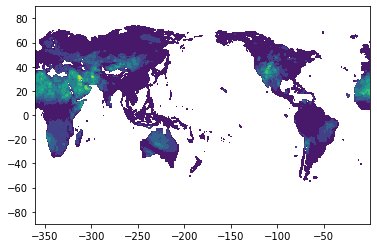

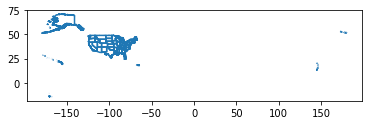

In [26]:
plt.contourf(ds.Longitude, ds.Latitude, ds['FWI'][160,:,:])
#plt.xlim([230,250])
#plt.ylim([40,50])
states.boundary.plot()
plt.show()

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

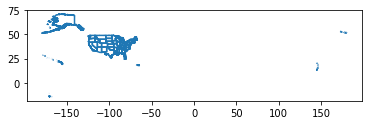

In [27]:
# Load the US states shapefile from Geopandas
states = gpd.read_file('../cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
states.boundary.plot()
states.crs
#states = states.to_crs("EPSG:3395")

In [207]:
# Load the CSV file into a DataFrame
data = pd.read_csv('testBatch.csv') # data format: 1st line -- date format, latitude, ffmc, dmc, and dc values
                                    ## 2nd line --- temperature, relative humidity, wind speed, and rain

## initialize the relevant fire variables, i.e., ffmc, dmc, dc. 
## Calculation of ISI, BUI, FWI does not value of previous time step and therefore doesn't need to be initialized. 
N = data.shape[0]
ffmc = np.zeros(N+1)
dmc = np.zeros(N+1)
dc = np.zeros(N+1)
isi = np.zeros(N+1)
bui = np.zeros(N+1)
fwi = np.zeros(N+1)
    
ini_val = data.columns.tolist()
lat = float(ini_val[-4])
ffmc[0] = float(ini_val[-3]) # read in the initial value from the title of the data
dmc[0] = float(ini_val[-2])
dc[0] = float(ini_val[-1])

# Rename columns. Note that the initial value of ffmc, dmc, dc and fwi will now be replaced with 'ffmc','dmc','dc','fwi'
df = data.reset_index()
df.columns = ['Date', 'Temp', 'RH', 'Wind', 'Rain', 'Data','format','ffmc','dmc','dc','fwi']
df = df.drop(columns=['ffmc','dmc','dc','fwi'], axis=1)  ## to remove confusion, drop these columns. 


for ii in range(1,N+1):
    ffmc[ii] = FFMC(df['Temp'][ii-1],df['RH'][ii-1],df['Wind'][ii-1],df['Rain'][ii-1],ffmc[ii-1])#TEMP,RH,WIND,RAIN,FFMCPrev)
    dmc[ii] = DMC(df['Temp'][ii-1],df['RH'][ii-1],df['Rain'][ii-1],dmc[ii-1],lat,int(df.Date[ii-1][:2]))#TEMP,RH,RAIN,DMCPrev,LAT,MONTH)
    dc[ii] = DC(df['Temp'][ii-1],df['Rain'][ii-1],dc[ii-1],lat,int(df.Date[ii-1][:2]))#TEMP,RAIN,DCPrev,LAT,MONTH)
    isi[ii] = ISI(df['Wind'][ii-1],ffmc[ii])
    bui[ii] = BUI(dmc[ii],dc[ii])
    fwi[ii] = FWI(isi[ii],bui[ii])
    #print(ii,isi[ii],bui[ii],fwi[ii])